# Titanic: Survival Model (XGBoost Version)

Build and train an XGBoost model to predict survival on the Titanic using a [cleaned and split dataset](https://huggingface.co/datasets/jamieoliver/titanic-2410), and upload the model to Hugging Face.

Based on https://github.com/jamieoliver/titanic-model-2410.

## Plan
- [x] Download [cleaned and split dataset](https://huggingface.co/datasets/jamieoliver/titanic-2410) from Hugging Face
- [x] Prepare data for model
  - [x] Load dataset splits as Pandas DataFrames
- [x] Build and train initial model
- [x] Tune model hyperparameters
- [ ] Test final model
- [ ] Upload model to Hugging Face

## Download Cleaned and Split Dataset From Hugging Face

In [1]:
from datasets import *

datasetDict = load_dataset('jamieoliver/titanic-2410')
datasetDict

DatasetDict({
    train: Dataset({
        features: ['survived', 'name', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'log_fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
        num_rows: 1047
    })
    validation: Dataset({
        features: ['survived', 'name', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'log_fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
        num_rows: 131
    })
    test: Dataset({
        features: ['survived', 'name', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'log_fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
        num_rows: 131
    })
})

## Prepare Data for Model

### Load Dataset Splits as Pandas DataFrames

The dependent variable is the variable we are predicting i.e. `survived`:

In [2]:
dependent_var = {split: dataset.to_pandas()['survived'] for split, dataset in datasetDict.items()}
dependent_var

{'train': 0        True
 1       False
 2       False
 3       False
 4       False
         ...  
 1042     True
 1043    False
 1044     True
 1045    False
 1046    False
 Name: survived, Length: 1047, dtype: bool,
 'validation': 0       True
 1      False
 2      False
 3       True
 4      False
        ...  
 126    False
 127    False
 128    False
 129    False
 130     True
 Name: survived, Length: 131, dtype: bool,
 'test': 0       True
 1      False
 2      False
 3      False
 4      False
        ...  
 126    False
 127    False
 128     True
 129    False
 130     True
 Name: survived, Length: 131, dtype: bool}

The independent variables are the variables we will use to make the prediction:

In [3]:
independent_cols = ['age', 'sibsp', 'parch', 'log_fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
                    'embarked_C', 'embarked_Q', 'embarked_S']

independent_vars = {split: dataset.to_pandas()[independent_cols] for split, dataset in datasetDict.items()}
independent_vars

{'train':        age  sibsp  parch  log_fare  pclass_1  pclass_2  pclass_3  sex_female  \
 0      4.0      1      1  3.178054     False      True     False        True   
 1     20.0      0      0  2.188856     False     False      True       False   
 2     32.5      0      0  5.358942      True     False     False       False   
 3     23.0      0      0  2.775447     False      True     False       False   
 4     47.0      0      0  3.970292      True     False     False       False   
 ...    ...    ...    ...       ...       ...       ...       ...         ...   
 1042  24.0      1      2  4.189655     False      True     False        True   
 1043  24.0      0      0  2.775447     False      True     False       False   
 1044  45.0      0      1  4.164466      True     False     False        True   
 1045  24.0      1      0  2.738146     False     False      True        True   
 1046  24.0      0      0  2.145931     False     False      True       False   
 
       sex_male  

## Build and Train Initial Model

In [4]:
import xgboost as xgb

dtrain = xgb.DMatrix(independent_vars['train'], label=dependent_var['train'])
dvalid = xgb.DMatrix(independent_vars['validation'], label=dependent_var['validation'])

In [5]:
import numpy as np

def accuracy(predictions, dtrain):
  dependent_var = dtrain.get_label()
  return 'accuracy', np.sum((predictions > 0.5) == dependent_var) / len(dependent_var)

In [6]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.3,
          'max_depth': 2}

In [7]:
model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.32366	validation-accuracy:0.64885
[1]	validation-mae:0.28908	validation-accuracy:0.81679
[2]	validation-mae:0.26536	validation-accuracy:0.81679


In [8]:
predictions = model.predict(dvalid)
results = (predictions > 0.5) == dependent_var['validation']
results[:20]

0     False
1      True
2      True
3      True
4      True
5     False
6      True
7      True
8      True
9      True
10     True
11    False
12     True
13    False
14     True
15    False
16     True
17    False
18     True
19    False
Name: survived, dtype: bool

## Tune Model Hyperparameters

### eta

In [9]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.2,
          'max_depth': 2}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.33282	validation-accuracy:0.64885
[1]	validation-mae:0.30626	validation-accuracy:0.64885
[2]	validation-mae:0.28525	validation-accuracy:0.64885


In [10]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.5,
          'max_depth': 2}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.30534	validation-accuracy:0.64885
[1]	validation-mae:0.26527	validation-accuracy:0.81679
[2]	validation-mae:0.24618	validation-accuracy:0.81679
[3]	validation-mae:0.23616	validation-accuracy:0.81679


In [11]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.6,
          'max_depth': 2}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.29618	validation-accuracy:0.74046
[1]	validation-mae:0.25863	validation-accuracy:0.77099
[2]	validation-mae:0.24470	validation-accuracy:0.77863


`eta = 0.5` maintains accuracy while minimising the loss.

### max_depth

In [12]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.5,
          'max_depth': 1}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.29771	validation-accuracy:0.64885
[1]	validation-mae:0.28435	validation-accuracy:0.81679
[2]	validation-mae:0.27099	validation-accuracy:0.75572
[3]	validation-mae:0.26431	validation-accuracy:0.75572


In [13]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.5,
          'max_depth': 3}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.28626	validation-accuracy:0.64885
[1]	validation-mae:0.25382	validation-accuracy:0.80153
[2]	validation-mae:0.22805	validation-accuracy:0.83206
[3]	validation-mae:0.22376	validation-accuracy:0.77863


In [14]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.5,
          'max_depth': 4}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=10,
                  evals=[(dvalid, 'validation')],
                  early_stopping_rounds=3,
                  custom_metric=accuracy)

[0]	validation-mae:0.29008	validation-accuracy:0.64885
[1]	validation-mae:0.25382	validation-accuracy:0.78626
[2]	validation-mae:0.23569	validation-accuracy:0.78626


`max_depth = 3` with `num_boost_round=3` gives the best accuracy and loss.

### Final Model

In [15]:
params = {'device': 'cuda',
          'objective': 'reg:absoluteerror',
          'eta': 0.5,
          'max_depth': 3}

model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=3,
                  evals=[(dvalid, 'validation')],
                  custom_metric=accuracy)

[0]	validation-mae:0.28626	validation-accuracy:0.64885
[1]	validation-mae:0.25382	validation-accuracy:0.80153
[2]	validation-mae:0.22805	validation-accuracy:0.83206


<Axes: >

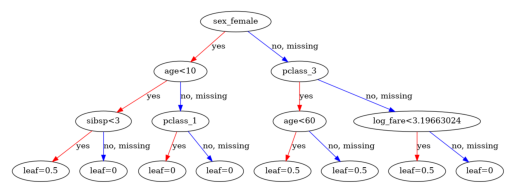

In [16]:
xgb.plot_tree(model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

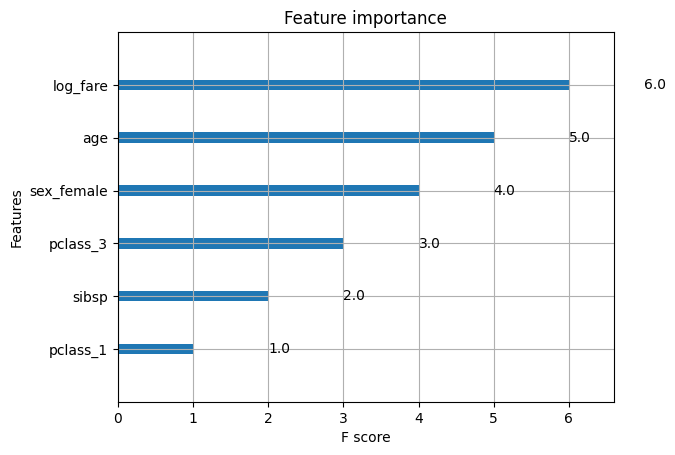

In [17]:
xgb.plot_importance(model)